# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [37]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
DEVICE = 'cuda:0'
NDIM = 4 # number of parameters
NBINS = 1000

In [39]:
SIGMA = 0.05
def model(z):
    x = sum((z-0.5)**2)**0.5  # Return radial distance from center
    return np.array([x])

def noisemodel(x, z = None):
    n = np.random.randn(*x.shape)*SIGMA  #*noiselevel
    return x + n

In [40]:
z0 = np.array([0.2, 0.5,0.6,0.4])
x0 = noisemodel(model(z0))
x0

array([0.34307613])

In [41]:
ds = swyft.DataStoreZarr("/home/aecole/swyft/notebooks/SP.zarr")
ds.init(zdim = NDIM, xdim = (1,))

Loading datastore: /home/aecole/swyft/notebooks/SP.zarr


In [58]:
sw_list = []

for i_round in range(1):
    parent = None if len(sw_list) == 0 else sw_list[-1]
    sw = swyft.SWYFT(x0, zdim = NDIM, device = DEVICE, head = None, datastore = ds, nsamples = 15000, noisemodel = noisemodel, parent = parent)
    sw_list.append(sw)
    
    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    sw.train1d(max_epochs = 100, nbatch = 16)

Constrained posterior area: 1.0
Adding 4968 new samples. Run simulator!
Start training
LR iteration 0
Total epochs: 9
Validation losses: [10.598476469516754, 10.56833130121231, 10.603930026292801, 10.547962635755539, 10.576408237218857, 10.52736184000969, 10.573801070451736, 10.581515282392502, 10.56130263209343]
LR iteration 1
Total epochs: 4
Validation losses: [10.477737456560135, 10.537146389484406, 10.518250912427902, 10.540010929107666]
LR iteration 2
Total epochs: 4
Validation losses: [10.510829091072083, 10.533555299043655, 10.546821236610413, 10.540125608444214]


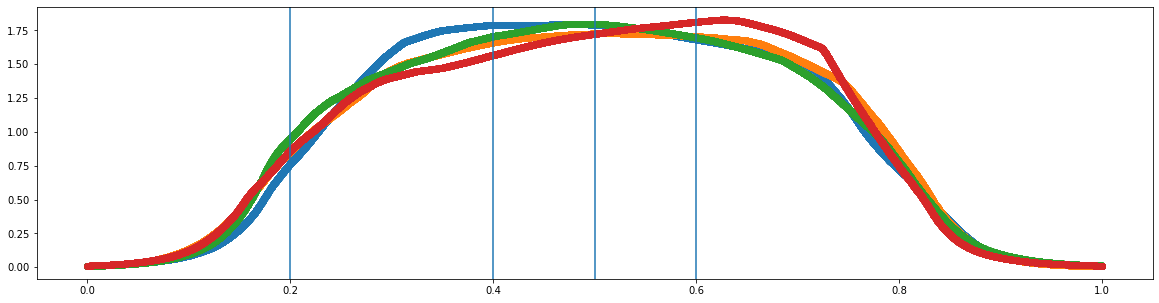

In [59]:
plt.figure(figsize=(20, 5))
for i in range(4):
    z, p = sw_list[-1].posterior(i)
    plt.axvline(z0[i])
    plt.scatter(z, p)

In [60]:
sw_list[-1].trainNd([[0, 1]], max_epochs = 100, nbatch = 16)

Start training
LR iteration 0
Total epochs: 11
Validation losses: [2.5033181458711624, 2.5108508802950382, 2.4922932609915733, 2.490481123328209, 2.4786230698227882, 2.5054658129811287, 2.4980090484023094, 2.4781483858823776, 2.496260702610016, 2.499063804745674, 2.4902941174805164]
LR iteration 1
Total epochs: 9
Validation losses: [2.4307487793266773, 2.452935740351677, 2.435730703175068, 2.417505133897066, 2.4612566269934177, 2.4099692702293396, 2.4460960254073143, 2.4776784852147102, 2.470492549240589]
LR iteration 2
Total epochs: 10
Validation losses: [2.471146084368229, 2.4641226455569267, 2.4873908907175064, 2.464653506875038, 2.4392206594347954, 2.4745228476822376, 2.437228724360466, 2.461419276893139, 2.443811897188425, 2.4833258986473083]


In [65]:
ds.__len__()

14902

In [66]:
#import torch
#import matplotlib.pyplot as plt
from swyft import posteriors

'''def posteriors(x0, net, dataset, combinations = None, device = 'cpu'):
    x0 = x0.to(device)
    z = torch.stack(swyft.get_z(dataset)).to(device)
    z = torch.stack([swyft.combine_z(zs, combinations) for zs in z])
    lnL = swyft.get_lnL(net, x0, z)
    return z.cpu(), lnL.cpu()'''

# Grid over which to evaluate 2D posterior
n_unique = 150
#z_unique = torch.stack(
z_unique = [{"z": z} for z in torch.stack(
    torch.meshgrid([
        torch.linspace(0., 1., n_unique),
        torch.linspace(0., 1., n_unique),
    ])
).flatten(1).t()]
def get_lnLs(net, x, z_unique):
    """
    Gets lnL evaluated over the specified unique z values
    """
    z_grid, lnL_grid = posteriors(
        x.to(DEVICE), net, z_unique, combinations=[[0, 1]], device=DEVICE
    )
    z_grid = z_grid.squeeze()  # <--- map z to physical parameters here
    lnL_grid = lnL_grid.squeeze()
    return (
        z_grid[:, 0].reshape([n_unique, n_unique]),
        z_grid[:, 1].reshape([n_unique, n_unique]),
        lnL_grid.reshape([n_unique, n_unique])
    )
def plot_pos_contour(net, x, ax, z_unique, p_vals=[0.68, 0.95, 0.997]):
    """
    Computes swyft contours for a set of noise realizations.
    """
    # Get posterior over grid
    x_grid, y_grid, lnL_grid = get_lnLs(net, x, z_unique)
    x_grid = x_grid.reshape([n_unique, n_unique])
    y_grid = y_grid.reshape([n_unique, n_unique])
    L_grid = lnL_grid.reshape([n_unique, n_unique]).exp()
    # Compute containment regions
    # Parameter space area around each point in (x_grid, y_grid)
    sq_area = (
        (x_grid[1, 0] - x_grid[0, 0]) * (y_grid[0, 1] - y_grid[0, 0])
    )
    # Compute posterior mass fraction in that region
    frac_mass = L_grid * sq_area
    frac_mass /= frac_mass.sum()
    # For each value of L, compute fraction of posterior mass around points with
    # higher L
    sorted_Ls = torch.sort(L_grid.flatten()).values    
    containment = torch.zeros(L_grid.numel())
    for i, L in enumerate(sorted_Ls):
        containment[i] = frac_mass[L_grid >= L].sum()
    # Figure out mapping from p values to L values
    levels = [0] + [
        sorted_Ls[torch.where(containment < p)[0][0]].item() for p in np.sort(p_vals)[::-1]
    ]
    cs = ax.contour(
        x_grid, y_grid, L_grid, levels=levels, colors=p_val_colors,
        #x_grid, y_grid, L_grid, levels=levels,
        #labels=np.sort(p_vals)[::-1]
        #labels=['68%','95%','99.7%']
    )
    return cs
# Usage example: sw has a netNd_store with a trained network and x is the
# observation to analyze
#plt.figure()
#plot_pos_contour(sw.netNd_store[-1], x, plt.gca(), z_unique)

In [62]:
p_val_colors=['green','red','blue']

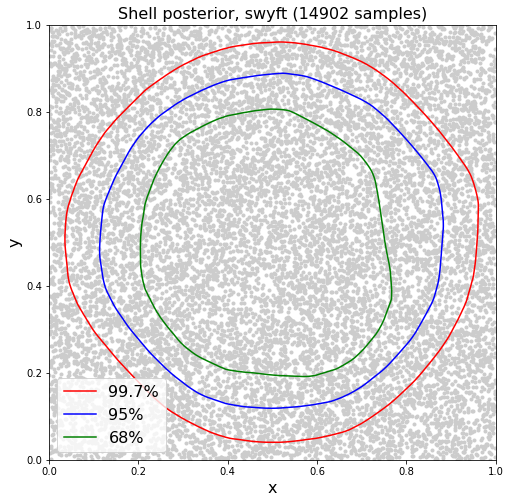

In [68]:
zgrid, lnLgrid = sw_list[-1].posterior([0, 1])
fig,ax=plt.subplots(figsize=(8,8))
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
cs=plot_pos_contour(sw.netNd["default"]['net'], torch.tensor(x0).float(), plt.gca(), z_unique)
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)
plt.xlim([0.0,1.0])
plt.ylim([-0.0, 1.0])
#cs.levels = [nf(val) for val in cs.levels]
# Label levels with specially formatted floats
#if plt.rcParams["text.usetex"]:
#    fmt = r'%r \%%'
#else:
#    fmt = '%r %%'
#ax.clabel(cs, inline=True, fontsize=16,labels=["68","95","99.7"]);
plt.plot([3,4],[5,6],color='red',label="99.7%")
plt.plot([3,4],[5,6],color='blue',label="95%")
plt.plot([3,4],[5,6],color='green',label="68%");
plt.legend(fontsize=16,loc='lower left')
plt.title('Shell posterior, swyft (14902 samples)',fontsize=16)

plt.savefig('Figs/ShellPos2d1.png',dpi=300)

In [153]:
np.random.seed(26)
torch.manual_seed(26)
z1 = np.array([0.2, 0.5,])
x1 = noisemodel(model(z1))

In [154]:
sw2_list = []

for i_round in range(1):
    parent = None if len(sw2_list) == 0 else sw2_list[-1]
    sw2 = swyft.SWYFT(x1, zdim = 2, device = DEVICE, head = None, datastore = ds, nsamples = 5000, noisemodel = noisemodel, parent = parent)
    sw2_list.append(sw2)
    
    if sw2.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    sw2.train1d(max_epochs = 100, nbatch = 16)

Constrained posterior area: 1.0
No new simulator runs required.
Start training
LR iteration 0
Total epochs: 9
Validation losses: [4.906758405268192, 4.8443243354558945, 4.858029387891293, 4.859744101762772, 4.806840792298317, 4.78324282169342, 4.860641725361347, 4.9183953404426575, 4.821373328566551]
LR iteration 1
Total epochs: 8
Validation losses: [4.81962351500988, 4.805319279432297, 4.808961048722267, 4.864483803510666, 4.7594630271196365, 4.7878661304712296, 4.802099011838436, 4.8407998457551]
LR iteration 2
Total epochs: 4
Validation losses: [4.741398714482784, 4.766691878437996, 4.795493558049202, 4.765116751194]


In [ ]:
ds.__len__()

In [155]:
sw2_list[-1].trainNd([[0, 1]], max_epochs = 100, nbatch = 16)

Start training
LR iteration 0
Total epochs: 7
Validation losses: [1.705329094082117, 1.665695995092392, 1.7031268887221813, 1.5710066221654415, 1.607152733951807, 1.6050012819468975, 1.6174846347421408]
LR iteration 1
Total epochs: 8
Validation losses: [1.555745206773281, 1.6899723168462515, 1.571152312681079, 1.5167965739965439, 1.4868643321096897, 1.5497785583138466, 1.5649246461689472, 1.523416854441166]
LR iteration 2
Total epochs: 7
Validation losses: [1.58149603754282, 1.6021158806979656, 1.5448231752961874, 1.488774647936225, 1.5778290536254644, 1.5545927193015814, 1.5700003169476986]


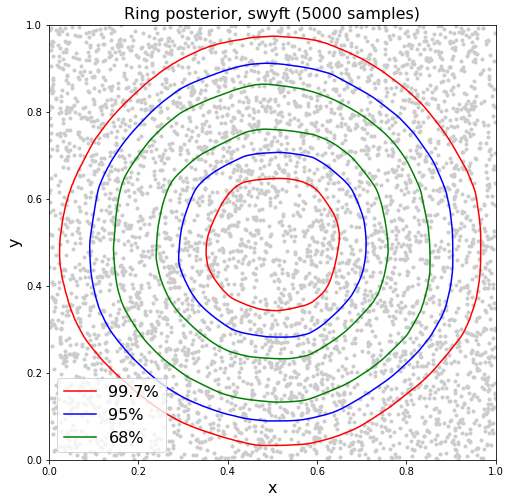

In [169]:
zgrid, lnLgrid = sw2_list[-1].posterior([0, 1])
fig,ax=plt.subplots(figsize=(8,8))
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
cs=plot_pos_contour(sw.netNd["default"]['net'], torch.tensor(x0).float(), plt.gca(), z_unique)
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)
plt.xlim([0.0,1.0])
plt.ylim([-0.0, 1.0])
#cs.levels = [nf(val) for val in cs.levels]
# Label levels with specially formatted floats
#if plt.rcParams["text.usetex"]:
#    fmt = r'%r \%%'
#else:
#    fmt = '%r %%'
#ax.clabel(cs, inline=True, fontsize=16,labels=["68","95","99.7"]);
plt.plot([3,4],[5,6],color='red',label="99.7%")
plt.plot([3,4],[5,6],color='blue',label="95%")
plt.plot([3,4],[5,6],color='green',label="68%");
plt.legend(fontsize=16, loc='lower left')
plt.title('Ring posterior, swyft (5000 samples)',fontsize=16)

plt.savefig('Figs/RingPos2d2.png',dpi=300)

In [157]:
torch.save(sw_list[-1].posterior([0,1]),'RingPost2d1.pt')
torch.save(sw2_list[-1].posterior([0,1]),'RingPost2d2.pt')

In [158]:
np.random.seed(26)
torch.manual_seed(26)
z2 = np.array([0.2, 0.5])
x2 = noisemodel(model(z2))

sw3_list = []

for i_round in range(1):
    parent = None if len(sw3_list) == 0 else sw3_list[-1]
    sw3 = swyft.SWYFT(x2, zdim = 2, device = DEVICE, head = None, datastore = ds, nsamples = 2500, noisemodel = noisemodel, parent = parent)
    sw3_list.append(sw3)
    
    if sw3.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    sw3.train1d(max_epochs = 100, nbatch = 16)

sw3_list[-1].trainNd([[0, 1]], max_epochs = 100, nbatch = 16)

Constrained posterior area: 1.0
No new simulator runs required.
Start training
LR iteration 0
Total epochs: 12
Validation losses: [5.0409481674432755, 4.918505504727364, 4.900732159614563, 4.874326854944229, 4.855847731232643, 4.885854512453079, 4.874719426035881, 4.841727614402771, 4.786769866943359, 4.820750877261162, 4.888495072722435, 4.836286842823029]
LR iteration 1
Total epochs: 5
Validation losses: [4.801274478435516, 4.751002162694931, 4.75443372130394, 4.803417161107063, 4.763007149100304]
LR iteration 2
Total epochs: 7
Validation losses: [4.7369227930903435, 4.805928714573383, 4.725222714245319, 4.714075714349747, 4.7932901084423065, 4.778436414897442, 4.738233536481857]
Start training
LR iteration 0
Total epochs: 8
Validation losses: [2.0816328413784504, 1.8296275325119495, 1.8103506099432707, 1.7480413392186165, 1.7301009837538004, 1.7324400544166565, 1.7436449639499187, 1.74279217235744]
LR iteration 1
Total epochs: 7
Validation losses: [1.670527197420597, 1.6144489943981

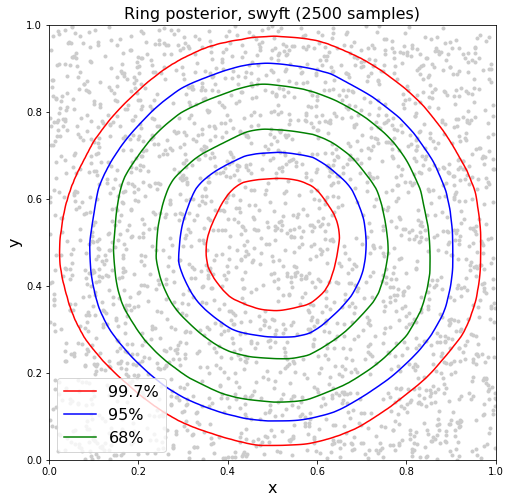

In [168]:
zgrid, lnLgrid = sw3_list[-1].posterior([0, 1])
fig,ax=plt.subplots(figsize=(8,8))
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
cs=plot_pos_contour(sw.netNd["default"]['net'], torch.tensor(x0).float(), plt.gca(), z_unique)
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)
plt.xlim([0.0,1.0])
plt.ylim([-0.0, 1.0])
#cs.levels = [nf(val) for val in cs.levels]
# Label levels with specially formatted floats
#if plt.rcParams["text.usetex"]:
#    fmt = r'%r \%%'
#else:
#    fmt = '%r %%'
#ax.clabel(cs, inline=True, fontsize=16,labels=["68","95","99.7"]);
plt.plot([3,4],[5,6],color='red',label="99.7%")
plt.plot([3,4],[5,6],color='blue',label="95%")
plt.plot([3,4],[5,6],color='green',label="68%");
plt.legend(fontsize=16, loc='lower left')
plt.title('Ring posterior, swyft (2500 samples)',fontsize=16)

plt.savefig('Figs/RingPos2d3.png',dpi=300)